In [ ]:
!pip install sentence_transformers
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sentence_transformers import SentenceTransformer, util
from sklearn.neighbors import NearestNeighbors

In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
model = SentenceTransformer('stsb-distilbert-base')
model.max_seq_length = 128

In [7]:
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
img_model = tf.keras.applications.MobileNet(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = 'imagenet' )

17225924/17225924 [==============================] - 2s 0us/step


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
def get_textEmbeddings(model,text):
    text_embedding = model.encode(text, convert_to_tensor=True)
    return text_embedding

In [10]:
def get_imageEmbeddings(model,imagePath):
    image = tf.keras.preprocessing.image.load_img(imagePath,target_size= size)
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    img_embeddings = model(input_arr)
    meanImgEmb1 = np.mean(img_embeddings,axis =0)
    meanImgEmb2 = np.mean(meanImgEmb1,axis=0)
    meanImgEmb = np.mean(meanImgEmb2,axis=0)
    return meanImgEmb

In [11]:
train_df = pd.read_excel("/content/outfits.xlsx")

In [13]:
train_df.head(5)

,product,gender,style,weather,match,colour
0,outfit0.jpg,female,casual,hot,match0.jpg,white
1,outfit1.jpg,female,formal,hot,match1.jpg,white
2,outfit2.jpg,male,casual,cold,match2.jpg,blue
3,outfit3.jpg,female,casual,hot,match3.jpg,black
4,outfit4.jpg,male,formal,cold,match4.jpg,grey


In [14]:
y= train_df.loc[:,"match"]

In [15]:
y.head(5)

0    match0.jpg
1    match1.jpg
2    match2.jpg
3    match3.jpg
4    match4.jpg
Name: match, dtype: object

In [17]:
gender_embeddings={}
style_embeddings={}
colour_embeddings={}
image_embeddings={}
for index,row in  train_df.iterrows():
    gender_emb = get_textEmbeddings(model,str(row[1]))
    style_emb = get_textEmbeddings(model,str(row[2]))
    colour_emb = get_textEmbeddings(model,str(row[5]))
    imagePath = '/content/drive/MyDrive/match/'+row[0]
    img_emb = get_imageEmbeddings(img_model,imagePath)
    gender_embeddings[row[0]] = gender_emb
    style_embeddings[row[0]] = style_emb
    colour_embeddings[row[0]] = colour_emb
    image_embeddings[row[0]] = img_emb

In [26]:
keyList=[]
cembList=[]
imageList=[]
genderList=[]
styleList=[]
colourList=[]
for index, row in train_df.iterrows():
    gender_emb = gender_embeddings[row[0]].cpu()
    print(np.shape(gender_emb))
    style_emb = style_embeddings[row[0]].cpu()
    print(np.shape(style_emb))
    colour_emb = colour_embeddings[row[0]].cpu()
    print(np.shape(gender_emb))
    img_emb = image_embeddings[row[0]]
    print(np.shape(img_emb))
    cmb_emb = np.concatenate((gender_emb,style_emb,colour_emb,img_emb),axis=0)
    print(np.shape(cmb_emb))
    norm = np.linalg.norm(cmb_emb)
    cmb_emb_normal = cmb_emb/norm
    keyList.append(row[0])
    cembList.append(cmb_emb_normal)
    imageList.append(row[0])
    genderList.append(row[1])
    styleList.append(row[2])
    colourList.append(row[5])

torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
to

In [27]:
from sklearn.neighbors import NearestNeighbors
kneigh = NearestNeighbors(n_neighbors=5,leaf_size=5000,algorithm='kd_tree')
kneigh.fit(cembList)

NearestNeighbors(algorithm='kd_tree', leaf_size=5000)

In [28]:
def getNeighbours(query_emb):
    posting_id_list=[]
    neigh_dist,neigh_ind = kneigh.kneighbors(X=query_emb.reshape(1,-1), n_neighbors=5, return_distance=True)
    for ind in neigh_ind:
        #print(str(ind))
        for ind1 in ind:
            posting_id_list.append(str(ind1))
    return posting_id_list

In [29]:
pic = "/content/test1.jpg"
gender = "female"
colour = "pink"
style = "casual"
gen_emb = get_textEmbeddings(model,gender).cpu()
sty_emb = get_textEmbeddings(model,style).cpu()
col_emb = get_textEmbeddings(model,colour).cpu()
pic_emb = get_imageEmbeddings(img_model,pic)
combined = np.concatenate((gen_emb,sty_emb,col_emb,pic_emb),axis=0)

In [30]:
matches = getNeighbours(combined)

In [31]:
matches

['6', '18', '19', '7', '16']

In [44]:
n = train_df.iloc[6]

In [45]:
n

product     outfit6.jpg
gender           female
style            casual
weather             hot
match        match6.jpg
colour             pink
Name: 6, dtype: object

In [46]:
mat = n[4]

In [47]:
mat

'match6.jpg'

In [50]:
from google.colab.patches import cv2_imshow
import cv2

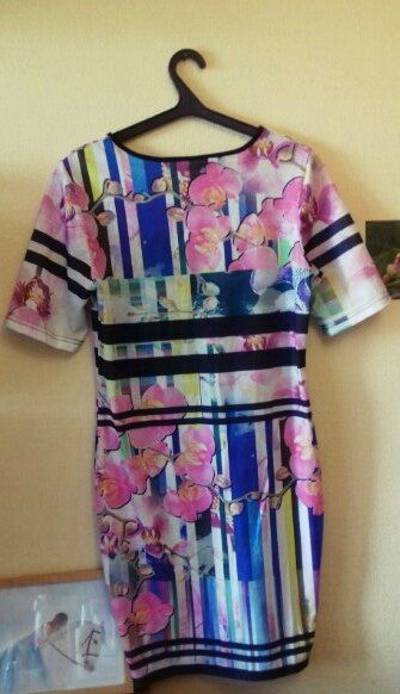

In [51]:
i = cv2.imread("/content/drive/MyDrive/match/"+mat,cv2.IMREAD_UNCHANGED)
cv2_imshow(i)
